# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [115]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [116]:
data = pd.read_csv('../data/Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


### Columns info:

1) FRESH: annual spending (m.u.) on fresh products (Continuous)

2) MILK: annual spending (m.u.) on milk products (Continuous)

3) GROCERY: annual spending (m.u.)on grocery products (Continuous)

4) FROZEN: annual spending (m.u.)on frozen products (Continuous) 

5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)

6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)

7) CHANNEL: customer's Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal) 

8) REGION: customer's Region “ Lisbon, Oporto or Other (Nominal) 

### No need to convert any categorical data since they are already integer type.

In [118]:
# missing data:

data.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

### No missing data to manage.

In [119]:
# collinearity:

corr = data.drop(['Channel', 'Region'], axis=1).corr()
corr

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


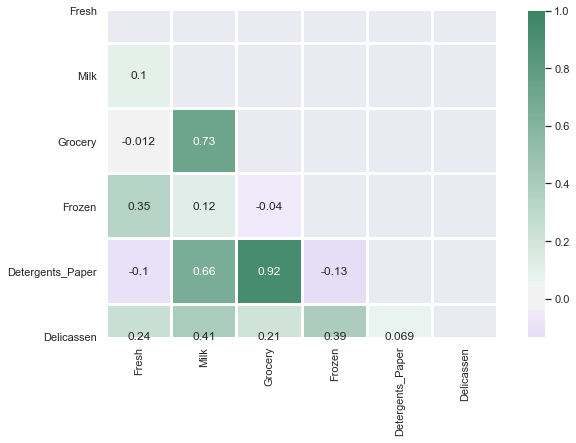

In [120]:
sns.set(rc={'figure.figsize':(11,6)})

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(275, 150, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=2, annot=True)

### High correlation between 'Grocery' and 'Detergents_Paper' (0.92), between 'Grocery' and 'Milk' (0.73) and between 'Detergents_Paper' and 'Milk' (0.66)

In [121]:
# descriptive stats:

data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [122]:
# Distribution and Outliers Visualization:

# Fresh:

px.histogram(data, x='Fresh')

In [123]:
# Milk:

px.histogram(data, x='Milk')

In [124]:
# Grocery:

px.histogram(data, x='Grocery')

In [125]:
# Frozen:

px.histogram(data, x='Frozen')

In [126]:
# Detergents_Paper

px.histogram(data, x='Detergents_Paper')

In [127]:
# Delicassen

px.histogram(data, x='Delicassen')

### All distributions are right-skewed, positive skeweness: mode < median < mean.

In [128]:
data.shape

(440, 8)

In [129]:
# Outliers treatment:


data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

'''
description:

For each column, first it computes the Z-score of each value in the column, 
relative to the column mean and standard deviation.
Then is takes the absolute of Z-score because the direction does not matter, 
only if it is below the threshold.

'''
data.shape

(414, 8)

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [130]:
# Already done: Outliers treatment. No need for NA's treatment.

In [131]:
# Encoding categorical features:

data = pd.get_dummies(data, prefix=['Channel', 'Region'], columns=['Channel', 'Region'])

In [132]:
data.head(2)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [134]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

customers_scale = scaler.fit_transform(data)

In [135]:
customers_scale = pd.DataFrame(customers_scale, columns=data.columns)
customers_scale.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,-5.443847e-17,9.493211e-17,-4.692972e-17,1.550022e-16,1.260398e-17,-1.319395e-16,-3.298489e-16,2.198992e-16,-1.418618e-16,-8.377625e-16,1.296333e-15
std,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-1.091911e+00,-1.058627e+00,-1.056245e+00,-8.667220e-01,-7.396316e-01,-1.015635e+00,-1.478044e+00,-6.765696e-01,-4.549693e-01,-3.492151e-01,-1.602799e+00
25%,-7.798750e-01,-7.459452e-01,-7.285642e-01,-6.429957e-01,-6.617023e-01,-6.932480e-01,-1.478044e+00,-6.765696e-01,-4.549693e-01,-3.492151e-01,-1.602799e+00
50%,-2.724241e-01,-2.949172e-01,-3.545156e-01,-3.785920e-01,-4.996813e-01,-2.935533e-01,6.765696e-01,-6.765696e-01,-4.549693e-01,-3.492151e-01,6.239084e-01
75%,5.042382e-01,4.475842e-01,4.572026e-01,2.246192e-01,4.016145e-01,3.649973e-01,6.765696e-01,1.478044e+00,-4.549693e-01,-3.492151e-01,6.239084e-01
max,3.910459e+00,4.613042e+00,4.338772e+00,4.932482e+00,4.601369e+00,5.432937e+00,6.765696e-01,1.478044e+00,2.197950e+00,2.863564e+00,6.239084e-01


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [136]:
from sklearn.cluster import KMeans

In [137]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(customers_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [138]:
kmeans.labels_

array([2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 2, 0, 0, 2, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 3, 2, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,

In [139]:
data['labels']= kmeans.labels_

Count the values in `labels`.

In [140]:
data.labels.value_counts()

0    200
2    117
3     60
1     37
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [141]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)
dbscan.fit(customers_scale)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [142]:
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
        0,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0, -1, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,  0,  0,
        0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1,
       -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        0, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [143]:
data['labels_DBSCAN']= dbscan.labels_

Count the values in `labels_DBSCAN`.

In [144]:
data['labels_DBSCAN'].value_counts()

-1    343
 0     71
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

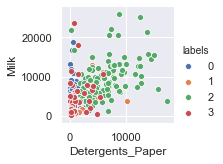

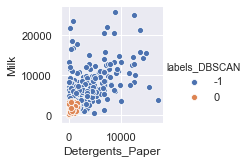

In [145]:
sns.pairplot(x_vars=['Detergents_Paper'], y_vars=['Milk'], data=data,
             hue='labels')
sns.pairplot(x_vars=['Detergents_Paper'], y_vars=['Milk'], data=data,
             hue='labels_DBSCAN')

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

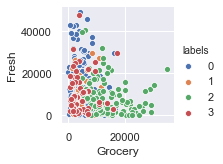

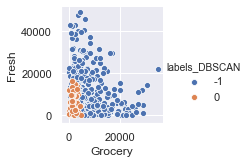

In [146]:
sns.pairplot(x_vars=['Grocery'], y_vars=['Fresh'], data=data,
             hue='labels')
sns.pairplot(x_vars=['Grocery'], y_vars=['Fresh'], data=data,
             hue='labels_DBSCAN')

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

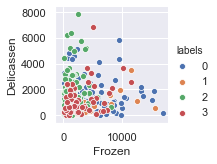

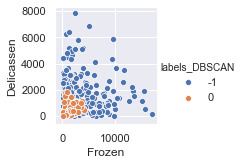

In [147]:
sns.pairplot(x_vars=['Frozen'], y_vars=['Delicassen'], data=data,
             hue='labels')
sns.pairplot(x_vars=['Frozen'], y_vars=['Delicassen'], data=data,
             hue='labels_DBSCAN')

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [148]:
data.groupby(['labels','labels_DBSCAN']).mean()

Fresh         Milk       Grocery       Frozen  \
labels labels_DBSCAN                                                         
0      -1             15440.170543  3923.403101   4350.666667  3840.457364   
        0              6218.647887  1521.352113   1940.478873  1428.915493   
1      -1             10432.729730  2821.918919   5309.756757  3219.000000   
2      -1              8178.162393  9125.162393  14326.299145  1407.504274   
3      -1             10975.100000  3846.416667   4156.100000  2916.750000   

                      Detergents_Paper   Delicassen  Channel_1  Channel_2  \
labels labels_DBSCAN                                                        
0      -1                   941.077519  1363.534884   1.000000   0.000000   
        0                   410.788732   565.563380   1.000000   0.000000   
1      -1                  1512.783784   983.081081   0.729730   0.270270   
2      -1                  6092.299145  1635.000000   0.008547   0.991453   
3      -1                  1054.133333  1146.450000   0.933333   0.066667   

                      Region_1  Region_2  Region_3  
labels labels_DBSCAN                                
0      -1             0.000000  0.000000  1.000000  
        0             0.000000  0.000000  1.000000  
1      -1             0.000000  1.000000  0.000000  
2      -1             0.094017  0.068376  0.837607  
3      -1             1.000000  0.000000  0.000000

Which algorithm appears to perform better?

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here